# Import

In [1]:
# System
import os
import time
import json

# Data processing
import numpy as np
import math

# Plot
import matplotlib.pyplot as plt

# ML
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# VAR
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler

# Config

In [2]:
# Config path
root = '/Volumes/Expansion/User_Backup/b08209033/111-2_IVT_analysis/'
folder = '2023_0321'
file = 'src/config.json'
config_path = os.path.join(os.path.join(root, folder), file)

# Import config
with open(config_path) as infile:
    config = json.load(infile)
    infile.close()

# Update config
#config.update({"ML_model_path": "./models/model.ckpt"})

# Export config
with open(config_path, 'w') as outfile:
    json.dump(config, outfile, sort_keys=True)
    outfile.close()

# Undetermined blocks

In [23]:

class My_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(My_Model, self).__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.GRU.weight_ih_l0.data.fill_(0)
        self.GRU.weight_hh_l0.data.fill_(0)
        self.input_length = input_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        
    def forward(self, x, hidden_state):
        hidden_state[-1] = 0
        output, hidden_state = self.GRU(x, hidden_state)
        return output, hidden_state
        #return output, x[:,0,:].reshape(1,-1,self.hidden_dim)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = torch.ones(self.num_layers, batch_size, self.hidden_dim)
        #hidden = weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [29]:
os.chdir(config["IVTPath"])

# VAR 
with np.load(config["IVT_SVD_fname"]) as dataset:
    time_structure = dataset['time']
    feature_num = int(dataset['feature_threshold'][0][0])
    # Choose k important structure
time_structure = (time_structure[:feature_num]).T
scaler = MinMaxScaler(feature_range=(-1,1))
time_structure = scaler.fit_transform(time_structure)
# GRU
test_loader = DataLoader(torch.load(config["ML_test_set_name"]), 
                         batch_size = config["ML_batch_size"], 
                         drop_last = True,
                         pin_memory = True)
os.chdir(config["ML_model_path"])
model = torch.load("model.pt")

In [30]:
# Define AR-p
AR_p = config["ML_seq_len"]
results = VAR(time_structure[:11780]).fit(maxlags = AR_p, trend='n')


In [31]:
model.eval() # Set your model to evaluation mode.

# GRU
preds = []
# VAR
expects = []
# Ground truth
targets = []
# And time index
times = []

hidden = model.init_hidden(config['ML_batch_size'])
for i, (x,y,t) in enumerate(test_loader):
    xn = x.detach().cpu().numpy()
    yn = y.detach().cpu().numpy()
    expect = []
    for j in range(len(xn)):
        temp = results.forecast(xn[j], config["ML_forecast_step"])
        expect.append(temp[-1])
    expects.append(expect)
    with torch.no_grad():
        pred, hidden = model(x, hidden)
        preds.append(pred.detach().cpu()[:,-1,:])
        targets.append(y.detach().cpu()[:,-1,:])
        times.append(t.detach().cpu()[:,-1,:])
preds = torch.cat(preds, dim=0).numpy()
targets = torch.cat(targets, dim=0).numpy()
expects = np.array(expects).reshape(-1, feature_num)
times = torch.cat(times, dim=0).numpy()

In [32]:
mean_error_GRU = np.mean(np.abs(preds[10:-10]-targets[10:-10]))
mean_error_VAR = np.mean(np.abs(expects[10:-10]-targets[10:-10]))
compare_rate = (mean_error_GRU -mean_error_VAR)/mean_error_VAR * 100
print(mean_error_GRU)
print(mean_error_VAR)
print(f"{compare_rate:.4f}" ,"%")

0.08478145
0.08458445765564544
0.2329 %


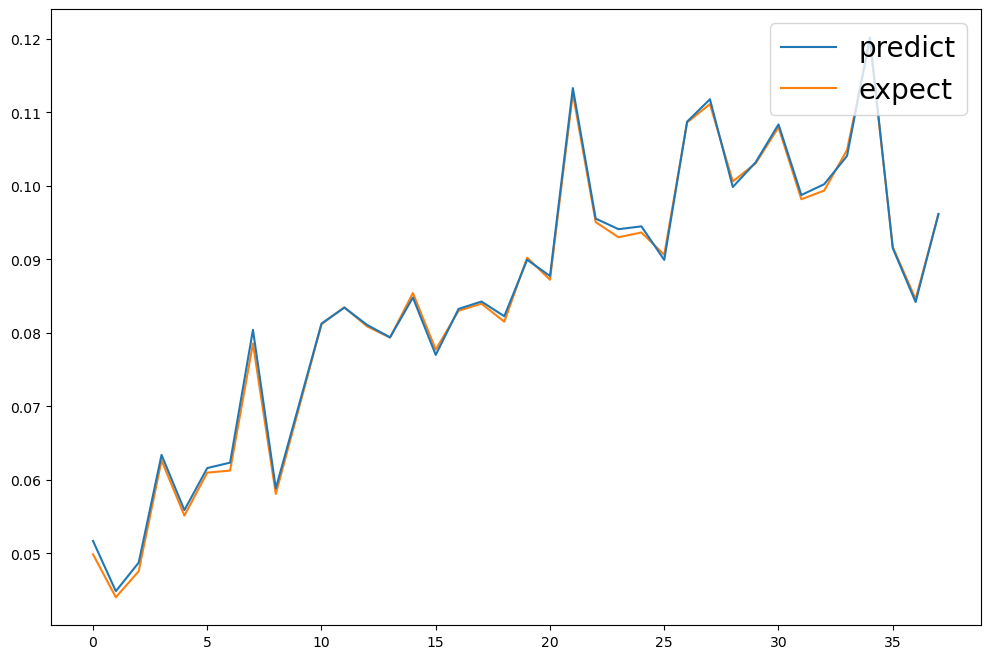

In [28]:
os.chdir(config["ImgPath"])
"""
t_interval = times[:,-1] - times[0,-1]
for idx in range(feature_num):
    plt.figure(figsize=(12,8), dpi = 100)
    plt.plot(t_interval,preds[:,idx], label = "predict", zorder = 5)
    plt.plot(t_interval,expects[:,idx], label = "expect", zorder = 4)
    #plt.plot(t_interval,targets[:,idx], label = "target", zorder = 3)
    plt.legend(loc = 1, prop={'size': 20})
    plt.title(f"Time structure of filtered SVD Spatial mode:{idx}")
    plt.savefig(f"Time series, mode:{idx}")
    plt.close()
"""
plt.figure(figsize=(12,8), dpi = 100)
error_pred = np.mean(np.abs(preds[:,:] - targets[:,:]), axis = 0)
error_exp = np.mean(np.abs(expects[:,:] - targets[:,:]), axis = 0)
plt.plot(error_pred, label = "predict", zorder = 5)
plt.plot(error_exp, label = "expect", zorder = 4)
plt.legend(loc = 1, prop={'size': 20})
plt.show()

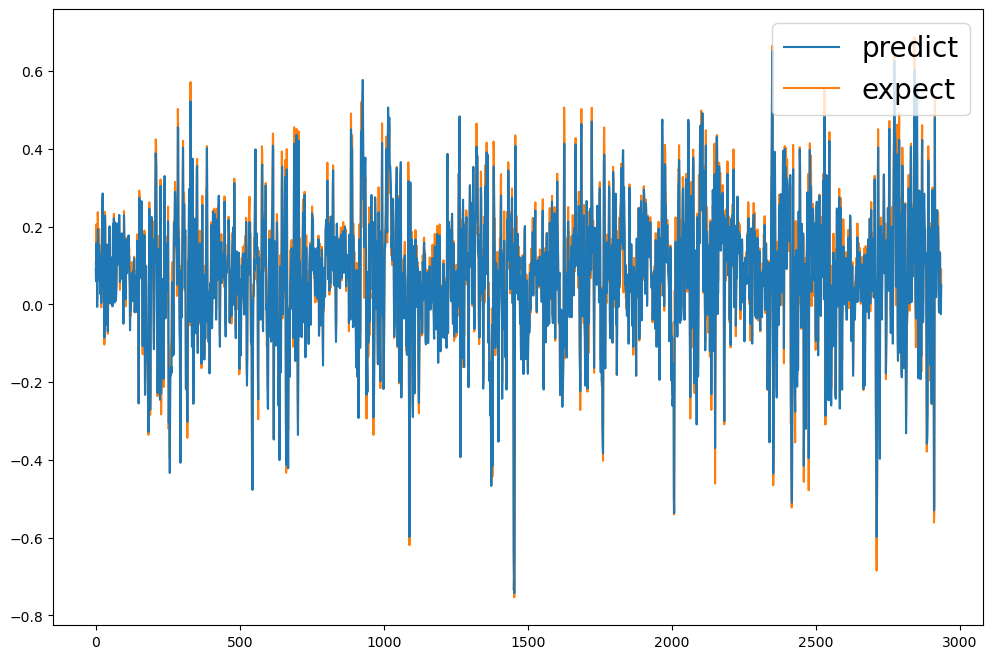

In [9]:
feat = 8
plt.figure(figsize=(12,8), dpi = 100)
plt.plot(preds[:,feat], label = "predict", zorder = 5)
plt.plot(expects[:,feat], label = "expect", zorder = 4)
plt.legend(loc = 1, prop={'size': 20})
plt.show()

# Unused blocks